## imaging the current profiles using a variable magnetic field

In [208]:
# this is necessary if using a module with external functions, in this case if file will be modified, functions will reload.
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.signal
import kwant
%run matplotlib_setup.ipy
from matplotlib import pyplot as plt
import aux_funcs
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
from types import SimpleNamespace
import copy
from cmath import exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
lat = kwant.lattice.square(norbs=1)

In [3]:
def make_wire(W=10, L=5, t=1):
    
    # bulk disorder
    def onsite(site, params):
        return params.U0 * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t
    
    # walls roughness (disorder)
    def on_edge(site, params):
        return  params.Uw * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t

    # magnetic field
    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos  
        return -t*exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    
    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    sr[lat.neighbors()] = hopping
    
    # make walls rough
    for site in aux_funcs.edges(sr, lat):
        sr[site] = on_edge
        
    
    # Build and attach lead from both sides.
    lead = kwant.Builder(kwant.TranslationalSymmetry([-1,0]))
    lead[(lat(0,y) for y in range(W))] = 4*t
    lead[lat.neighbors()] = hopping
    
    sr.attach_lead(lead)
    sr.attach_lead(lead.reversed())

    return sr

In [189]:
def get_wavefunction(syst, energy, lead, Uw, U0, phi, mode='all'):
    params = SimpleNamespace(Uw=Uw, U0=U0, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    wfs_abs = abs(wfs(lead))**2
    if mode=='all':
        density = np.sum(abs(wfs(lead))**2, axis=0)
    else:
        density = abs(wfs(lead)[mode,:])**2
    return density

def get_current(syst, energy, lead, Uw, U0, phi):
    params = SimpleNamespace(Uw=Uw, U0=U0, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    cur = kwant.operator.Current(syst).bind(args = [params])
    
    js = []
    
    print(wfs(lead).shape)
    for i in range(wfs(lead).shape[0]):
        js.append(cur(wfs(lead)[i,:]))
    return np.sum(np.array(js), axis=0)

# this returns a density which is closest to a flat line by obtaining the coefficienst of each wavefunction 
# from a least squares fit to a straight line. It works pretty well. 
def get_wavefunc_flat(syst, energy, lead, Uw, U0, phi, init_profile = None):
    params = SimpleNamespace(Uw=Uw, U0=U0, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    wfs_abs = abs(wfs(lead))**2
    
    if init_profile is None:
        init_profile = np.ones(wfs_abs.shape[1])
    
    coeffs = np.linalg.pinv(wfs_abs.T).dot(init_profile)
    wf_full = np.dot(wfs_abs.T, coeffs)
    wf_full = scipy.signal.filtfilt(np.ones(6)/6, 1, wf_full)
    return wf_full

# this is another attempt to optimize the weights of the wavefunctions for less osciallations, I think it didn't work.
def get_wf_linprog(syst, energy, lead, Uw, U0, phi):
    params = SimpleNamespace(Uw=Uw, U0=U0, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    wfs_abs = np.transpose(abs(wfs(lead))**2)
    m,n = wfs_abs.shape
    onesv = np.ones(n)
    init_profile = np.ones((m,1))
    c = np.hstack((1, np.zeros(n)))
    Aub = np.vstack((np.hstack((-np.ones((m,1)), wfs_abs)), np.hstack((-np.ones((m,1)), -wfs_abs))))
    b_ub = np.vstack((init_profile, -init_profile))
    bounds = [(None, None) for i in range(n+1)]
    print('started opt')
    sol = sp.optimize.linprog(c, Aub, b_ub, bounds = bounds, options = {'disp': True})
    coeffs_lp = sol.x[1:]
    wf_lp = np.dot(wfs_abs, coeffs_lp)
    return wf_lp

In [110]:
params = SimpleNamespace(Uw=0, U0=0, phi=0, salt=12);
wfs = kwant.wave_function(make_wire(W=20).finalized(), 0.2, args=[params])
wfs_abs = np.transpose(abs(wfs(0))**2)
coeffs = np.linalg.pinv(wfs_abs).dot(np.ones(wfs_abs.shape[0]))
wf_full = np.dot(wfs_abs, coeffs)
m,n = wfs_abs.shape
print(m); print(n)
onesv = np.ones(n)
init_profile = np.ones((m,1))
c = np.hstack((1, np.zeros(n)))
Aub = np.vstack((np.hstack((-np.ones((m,1)), wfs_abs)), np.hstack((-np.ones((m,1)), -wfs_abs))))
b_ub = np.vstack((init_profile, -init_profile))
bounds = [(None, None) for i in range(n+1)]

sol = sp.optimize.linprog(c, Aub, b_ub, bounds = bounds, options = {'disp': True})
coeffs_lp = sol.x[1:]
wf_lp = np.dot(wfs_abs, coeffs_lp)

100
3
Optimization terminated successfully.
         Current function value: 0.690145    
         Iterations: 103


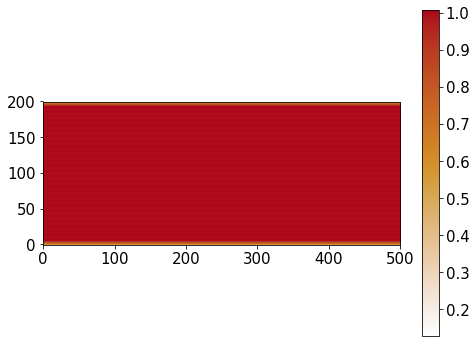

In [150]:
sys = make_wire(W=200, L=500).finalized()
wf_reg = get_wavefunction(sys, 0.2, 0, 0, 0, 0)
wf_flat = get_wavefunc_flat(sys, 0.2, 0, 0, 0, 0)
#wf_lp = get_wf_linprog(sys, 0.2, 0, 0, 0, 0)
kwant.plotter.map(sys, wf_flat);

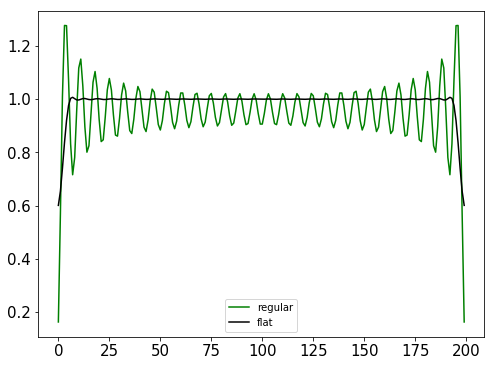

In [151]:
res_reg = aux_funcs.linecut_at_dim(sys, lat, wf_reg, 1, 2)
res_flat = aux_funcs.linecut_at_dim(sys, lat, wf_flat, 1, 2)
#res_lp = aux_funcs.linecut_at_dim(sys, lat, wf_lp, 1, 2)
plt.plot(res_reg['positions'], res_reg['wavefunc']/0.239, 'g')
plt.plot(res_flat['positions'], res_flat['wavefunc'])
#plt.plot(res_lp['positions'], res_lp['wavefunc'], 'b')
plt.legend(['regular', 'flat']);

In [176]:
sys = make_wire(W=50, L=200).finalized()

In [188]:
wfp[0]

(-0.089704361714204858-0.081679120283289247j)

7


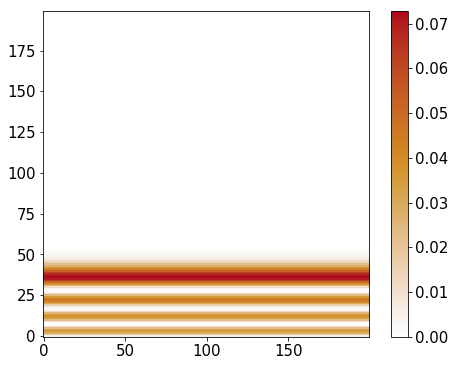

In [231]:
phi = 0.005
smat = kwant.smatrix(sys, 0.2, args=[params])
print(smat.num_propagating(0))
wfp = get_wavefunction(sys, 0.2, 0, 0, 0, phi, mode=3)
#wfm = get_wavefunc_flat(sys, 0.2, 0, 0, 0, -phi)
#cur_v = wfp-wfm
kwant.plotter.map(sys, wfp);

# optimizing for less oscillations

The idea here is to do a least squares fit to the a straight line whose slope is given by 

[-0.00038184  0.33327312]
(67, 500)


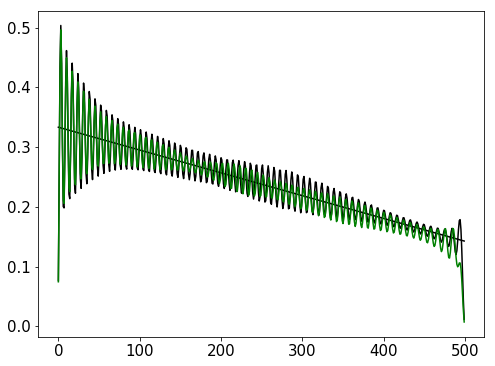

In [236]:
phi = 0.001
params = SimpleNamespace(Uw=0, U0=0, phi=phi, salt=12);
sys = make_wire(W=500, L=200).finalized()
wavefunc_all = get_wavefunction(sys, 0.2, 0, 0, 0, phi)


# get the wavefunction with oscillations fit to a straight line
res = aux_funcs.linecut_at_dim(sys, lat, wavefunc_all, 1, 1)
x = res['positions']; y_full = res['wavefunc']
fp1 = np.polyfit(x, y_full, 1)
y_full_fit = fp1[0]*x + fp1[1]
print(fp1)
plt.plot(x, y_full)
plt.plot(x, y_full_fit);

# for get the profiles of each mode
num_prop = kwant.smatrix(sys, 0.2, args=[params]).num_propagating(0)
wf_profiles = np.zeros((num_prop, len(x)))
print(wf_profiles.shape)

for i in range(num_prop):
    wf_temp = get_wavefunction(sys, 0.2, 0, 0, 0, phi, mode = i)
    res = aux_funcs.linecut_at_dim(sys, lat, wf_temp, 1, 1)
    x = res['positions']; y = res['wavefunc']
    wf_profiles[i,:] = y
    #plt.plot(y)
    

# get the coefficients
coeffs = np.linalg.pinv(wf_profiles.T).dot(y_full_fit)
y_min_osc = np.dot(coeffs, wf_profiles)

# plot the fitted data
plt.plot(x, y_min_osc, 'g')

(14, 20000)


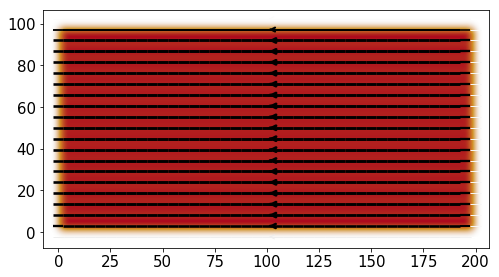

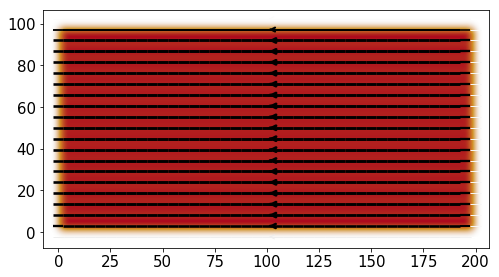

In [83]:
cur = get_current(sys, 0.2, 1, 0, 0, 0)
kwant.plotter.current(sys, cur);

[-0.00605016  0.39432673]


ValueError: shapes (6,10000) and (50,) not aligned: 10000 (dim 1) != 50 (dim 0)

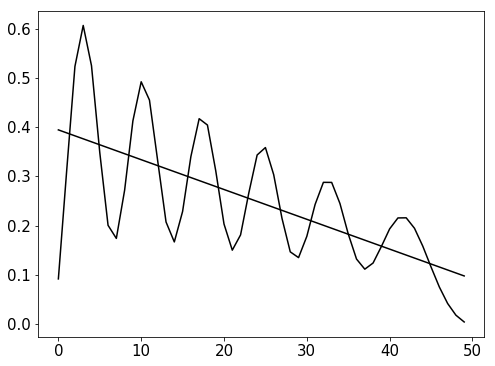

In [181]:
res = aux_funcs.linecut_at_dim(sys, lat, wfp, 1, 50)
x = res['positions']; y =
res['wavefunc']
fp1 = np.polyfit(x, y, 1)
print(fp1)
plt.plot(x, y)
plt.plot(x, fp1[0]*x + fp1[1])
wf_flat = get_wavefunc_flat(sys, 0.2, 0, 0, 0, phi, init_profile=fp1[0]*x + fp1[1])

In [ ]:
plt